# S.M.A.R.T QUESTIONS

1. Analisis Kunjungan Pasien
- Apakah ada pola tertentu dalam frekuensi kunjungan pasien berdasarkan tanggal pemeriksaan (tanggal_periksa)?
- Berapa rata-rata jumlah kunjungan per pasien dalam satu bulan? Apakah ada pasien yang sering berulang kali datang?
2. Analisis Berdasarkan Klinik dan Dokter
- Klinik atau poli mana yang paling sering dikunjungi pasien? Adakah hubungan antara jenis kunjungan (jenis_kunjungan) dengan klinik tertentu?
- Dokter mana yang memiliki jumlah pasien terbanyak? Adakah hubungan antara jumlah kunjungan dengan hari tertentu?
3. Analisis Status BPJS dan Keberhasilan Pengiriman
- Berapa persentase keberhasilan dan kegagalan status pengiriman data (status_kirim)? Apakah ada tren tertentu dalam data yang gagal terkirim?
- Adakah pola tertentu dalam kegagalan pengiriman berdasarkan jenis kunjungan atau poli tertentu?
4. Analisis Berdasarkan Jenis Kunjungan dan BPJS
- Jenis kunjungan (jenis_kunjungan) mana yang paling dominan dalam dataset? Apakah pasien dengan kunjungan tertentu lebih sering mengalami kegagalan pengiriman?
- Apakah pasien dengan nomor kartu BPJS yang sama sering berkunjung ke berbagai klinik atau hanya ke klinik tertentu?
5. Analisis Perbandingan Kinerja Berdasarkan Tanggal
- Apakah ada peningkatan atau penurunan jumlah pasien pada tanggal tertentu (misalnya, akhir pekan vs hari kerja)?
- Adakah hari tertentu dengan volume pasien tinggi yang menyebabkan peningkatan kegagalan pengiriman?
6. Identifikasi Pasien dengan Kunjungan Berulang dan Nomor BPJS
- Berapa banyak pasien yang melakukan lebih dari satu kunjungan dalam periode yang sama? Apakah mereka lebih rentan terhadap kegagalan pengiriman status?
- Apakah pasien dengan nomor BPJS tertentu lebih sering mengalami masalah status kirim?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.patches as mpatches 
from matplotlib.colors import LinearSegmentedColormap
import warnings 
import missingno as ms


warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.style.use('Solarize_Light2')


# Data Preparation

## Gathering Data

In [2]:
df_bpjs = pd.read_csv('./data/juli 2024.csv')

In [3]:
pd.DataFrame(df_bpjs)

,no_rawat,tanggal_periksa,nm_poli,nm_dokter,nm_pasien,no_rkm_medis,png_jawab,nomor_kartu,nomor_referensi,kodebooking,jenis_kunjungan,status_kirim
0,2024/07/01/000004,31/07/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M",MARNI Hj. Ny,97522.0,BPJS Kesehatan,1080583615,170603010624Y000093,1706R00620240731000020MAT004,3.0,Sudah
1,2024/07/01/000004,15/07/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M",MARNI Hj. Ny,97522.0,BPJS Kesehatan,1080583615,170603010724Y000496,1706R00620240715093247JIW005MJKN,1.0,Gagal
2,2024/07/01/000004,19/07/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M",MARNI Hj. Ny,97522.0,BPJS Kesehatan,1080583615,170603010624Y000093,1706R00620240719000016MAT001,3.0,Sudah
3,2024/07/01/000004,12/7/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M",MARNI Hj. Ny,97522.0,BPJS Kesehatan,1080583615,1706R0060624K003795,1706R00620240708034048KLT001MJKN,3.0,Gagal
4,2024/07/01/000004,15/07/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M",MARNI Hj. Ny,97522.0,BPJS Kesehatan,1080583615,170603010724Y000496,1706R00620240715000190JIW005,3.0,Sudah
...,...,...,...,...,...,...,...,...,...,...,...,...
1354,2024/07/04/000121,15/07/2024,KLINIK PENYAKIT DALAM,"dr. CHARISMA BIMARA COZY, M.Kes, Sp.PD","RIDUAN, Tn",224148.0,BPJS Kesehatan,2919164264,170604020624P001102,1706R00620240715000074INT003,3.0,Sudah
1355,2024/07/04/000121,22/07/2024,KLINIK PENYAKIT DALAM,"dr. CHARISMA BIMARA COZY, M.Kes, Sp.PD","RIDUAN, Tn",224148.0,BPJS Kesehatan,2919164264,170604020624P001102,1706R00620240722000120INT014,3.0,Sudah
1356,2024/07/04/000121,4/7/2024,KLINIK PENYAKIT DALAM,"dr. CHARISMA BIMARA COZY, M.Kes, Sp.PD","RIDUAN, Tn",224148.0,BPJS Kesehatan,2919164264,170604020624P001102,1706R00620240704000121INT018,3.0,Sudah
1357,2024/07/04/000123,25/07/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M",H.JONI KARLI,194620.0,BPJS Kesehatan,3304753233,170607010424P001248,1706R00620240725000061MAT019,3.0,Sudah


In [4]:
print(f"Unique of BPJS in the datasets : {len(df_bpjs.no_rawat.unique())}")

Unique of BPJS in the datasets : 640


## assesing data

In [5]:
df_bpjs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   no_rawat         1359 non-null   object 
 1   tanggal_periksa  1359 non-null   object 
 2   nm_poli          1358 non-null   object 
 3   nm_dokter        1358 non-null   object 
 4   nm_pasien        1358 non-null   object 
 5   no_rkm_medis     1358 non-null   float64
 6   png_jawab        1358 non-null   object 
 7   nomor_kartu      1305 non-null   object 
 8   nomor_referensi  1358 non-null   object 
 9   kodebooking      1358 non-null   object 
 10  jenis_kunjungan  1358 non-null   float64
 11  status_kirim     1358 non-null   object 
dtypes: float64(2), object(10)
memory usage: 127.5+ KB


- no_rawat (object): Nomor perawatan pasien, terdiri dari 1359 nilai yang semuanya terisi (tidak ada yang kosong).
- tanggal_periksa (object): Tanggal pemeriksaan pasien, terdiri dari 1359 nilai yang semuanya terisi.
- nm_poli (object): Nama poli (klinik) tempat pasien diperiksa, terdiri dari 1358 nilai yang terisi, artinya ada 1 nilai yang kosong.
- nm_dokter (object): Nama dokter yang menangani pasien, terdiri dari 1358 nilai yang terisi, ada 1 nilai yang kosong.
- nm_pasien (object): Nama pasien, terdiri dari 1358 nilai yang terisi, ada 1 nilai yang kosong.
- no_rkm_medis (float64): Nomor rekam medis pasien, terdiri dari 1358 nilai yang terisi, ada 1 nilai yang kosong.
- png_jawab (object): Penanggung jawab pembayaran, terdiri dari 1358 nilai yang terisi, ada 1 nilai yang kosong.
- nomor_kartu (object): Nomor kartu BPJS pasien, hanya 1305 nilai yang terisi, artinya ada 54 nilai yang kosong.
- nomor_referensi (object): Nomor referensi dari sistem antrian, terdiri dari 1358 nilai yang terisi, ada 1 nilai yang kosong.
- kodebooking (object): Kode booking pasien, terdiri dari 1358 nilai yang terisi, ada 1 nilai yang kosong.
- jenis_kunjungan (float64): Jenis kunjungan (misalnya rawat jalan, kontrol, dll.), terdiri dari 1358 nilai yang terisi, ada 1 nilai yang kosong.
- status_kirim (object): Status pengiriman data, terdiri dari 1358 nilai yang terisi, ada 1 nilai yang kosong.

In [6]:
print("DataFrame Tourism Information : ")
print(df_bpjs.isna().sum())

DataFrame Tourism Information : 
no_rawat            0
tanggal_periksa     0
nm_poli             1
nm_dokter           1
nm_pasien           1
no_rkm_medis        1
png_jawab           1
nomor_kartu        54
nomor_referensi     1
kodebooking         1
jenis_kunjungan     1
status_kirim        1
dtype: int64


<Axes: >

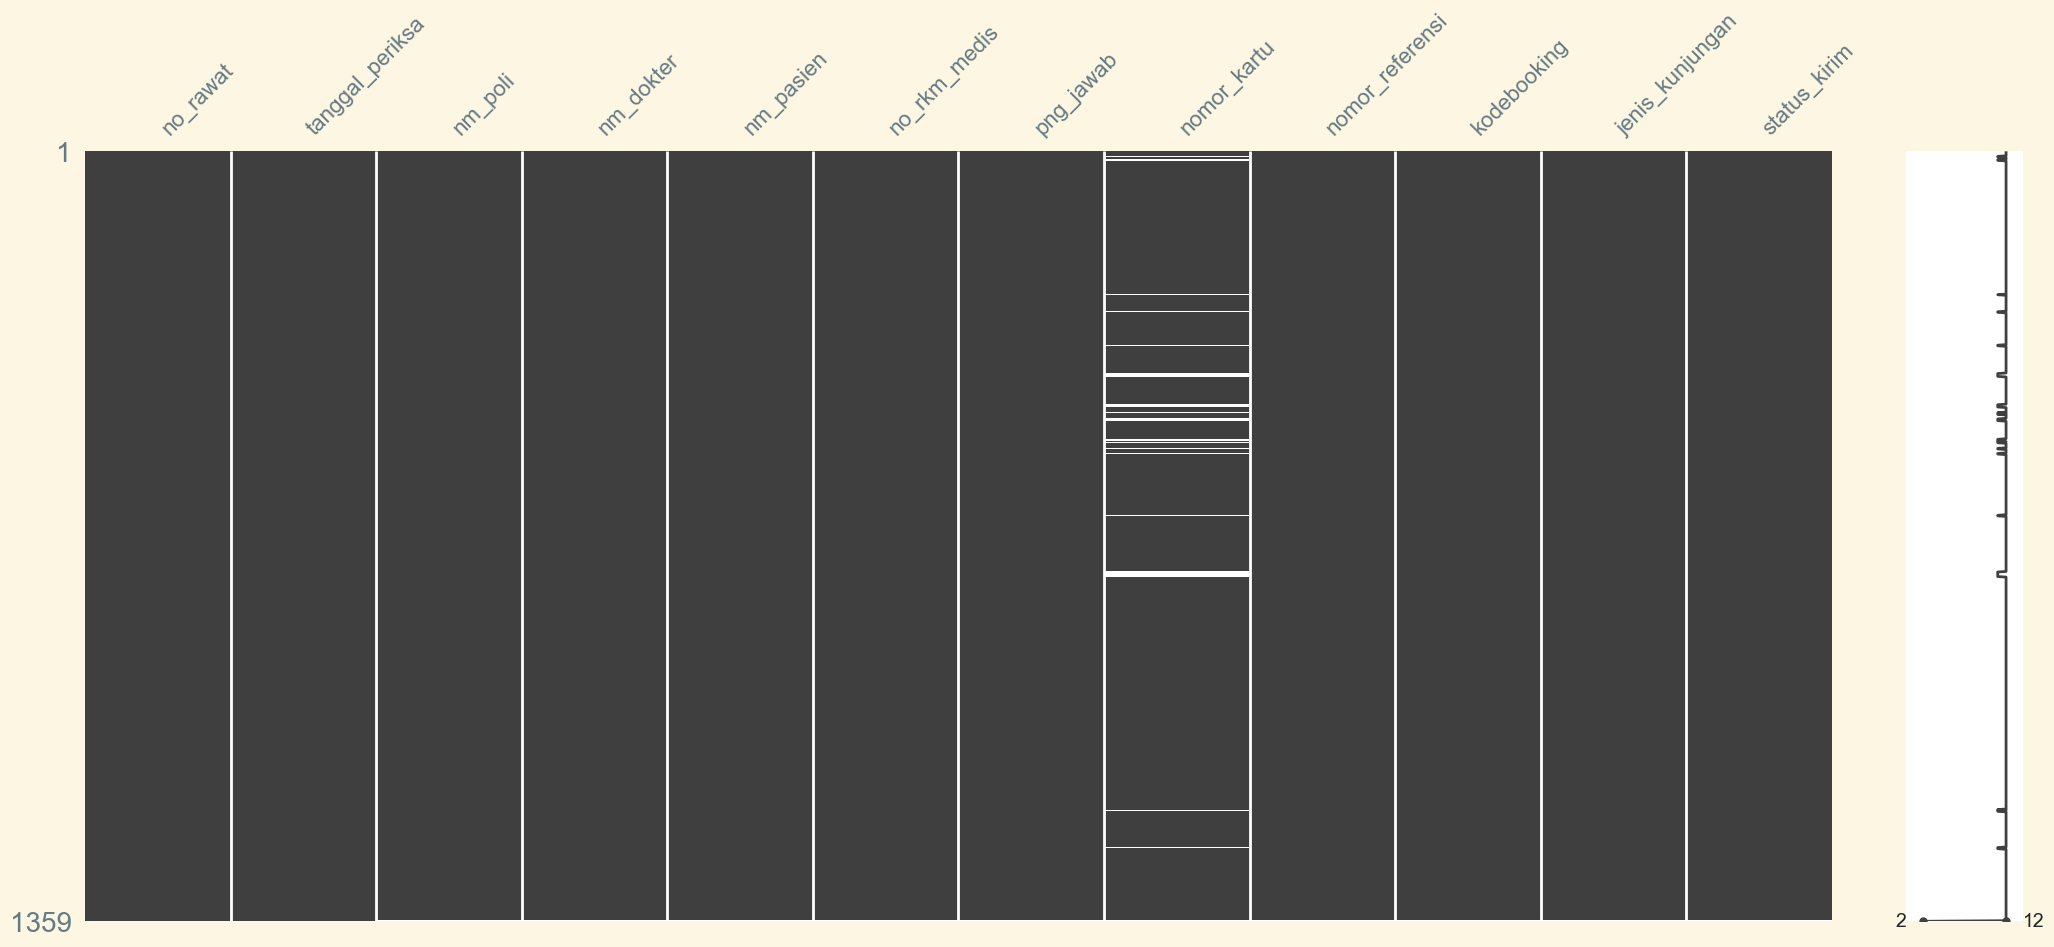

In [7]:
ms.matrix(df_bpjs)

In [8]:
df_bpjs.sample(10)

,no_rawat,tanggal_periksa,nm_poli,nm_dokter,nm_pasien,no_rkm_medis,png_jawab,nomor_kartu,nomor_referensi,kodebooking,jenis_kunjungan,status_kirim
318,2024/07/01/000178,8/7/2024,KLINIK PENYAKIT DALAM,"dr. CHARISMA BIMARA COZY, M.Kes, Sp.PD","RUSMINI, Ny",223716.0,BPJS Kesehatan,3225971643,170604020724P000249,1706R00620240708000178INT020,3.0,Gagal
276,2024/07/01/000157,19/07/2024,KLINIK BEDAH,"dr. H. Mujiran, Sp.B","DHONA LIDYA FEBRIYANTI, Ny",223543.0,BPJS Kesehatan,2752293543,170601010724P000877,1706R00620240719000010JIW001,3.0,Gagal
670,2024/07/02/000129,2/7/2024,KLINIK THT,"dr. Anita Nuraini, Sp.THT-KL",NORMANSYAH,186430.0,BPJS Kesehatan,2886875897,170601020724P000001,1706R00620240702000129THT008,3.0,Sudah
9,2024/07/01/000006,1/7/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M","HUMAIRA ZAHRA NUR, An",224024.0,UMUM,NaN,1706R00620240701000006004,1706R00620240701000006MAT004,3.0,Sudah
1064,2024/07/03/000236,9/7/2024,KLINIK GIGI,"drg. Hj. May Salamah Emma Ganefi, MM",SAPUWAN,61443.0,BPJS Kesehatan,124157057,170601010524P001039,1706R00620240709000172GIG005,3.0,Sudah
746,2024/07/02/000178,2/7/2024,KLINIK GIGI,"drg. Hj. May Salamah Emma Ganefi, MM",NADIAH SALMA AMIRAH AL FAWWAZ,224082.0,UMUM,NaN,1706R00620240702000178004,1706R00620240702000178GIG004,3.0,Sudah
1261,2024/07/04/000072,18/07/2024,KLINIK SARAF,"dr. Yenni Yustini, Sp. S","AMINUDDIN, Tn",880.0,BPJS Kesehatan,124282293,170601010624Y001421,1706R00620240718000066SAR008,3.0,Gagal
792,2024/07/03/000016,22/07/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M","ASHWIN PARDEDE, Tn",151562.0,BPJS Kesehatan,2446014003,0285U0230524P000086,1706R00620240722000010MAT004,3.0,Sudah
363,2024/07/01/000205,22/07/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M","LAMSIAH, Ny",221400.0,BPJS Kesehatan,3583585315,170601010624Y000133,1706R00620240722000312MAT061,3.0,Gagal
744,2024/07/02/000178,2/7/2024,KLINIK GIGI,"drg. Hj. May Salamah Emma Ganefi, MM",NADIAH SALMA AMIRAH AL FAWWAZ,224082.0,UMUM,NaN,1706R00620240702000178004,1706R00620240702000178GIG004,3.0,Sudah


In [9]:
print("summary data bpjs pasien duplicated : ", df_bpjs.duplicated().sum())

summary data bpjs pasien duplicated :  187


terdapat data pasien dari bpjs terduplikat 187 

In [10]:
df_bpjs.describe(include='all').style.background_gradient(cmap="RdPu")

,no_rawat,tanggal_periksa,nm_poli,nm_dokter,nm_pasien,no_rkm_medis,png_jawab,nomor_kartu,nomor_referensi,kodebooking,jenis_kunjungan,status_kirim
count,1359,1359,1358,1358,1358,1358.000000,1358,1305,1358,1358,1358.000000,1358
unique,640,27,12,17,595,nan,4,598,820,1090,nan,3
top,2024/07/01/000062,1/7/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M","LAMSIAH, Ny",nan,BPJS Kesehatan,2090136969,0285R0010624B000001,1706R00620240701000232SAR006,nan,Sudah
freq,18,308,357,357,23,nan,1215,18,16,9,nan,810
mean,nan,nan,nan,nan,nan,174983.564065,nan,nan,nan,nan,2.982327,nan
std,nan,nan,nan,nan,nan,56455.284575,nan,nan,nan,nan,0.187242,nan
min,nan,nan,nan,nan,nan,644.000000,nan,nan,nan,nan,1.000000,nan
25%,nan,nan,nan,nan,nan,144304.000000,nan,nan,nan,nan,3.000000,nan
50%,nan,nan,nan,nan,nan,194157.000000,nan,nan,nan,nan,3.000000,nan
75%,nan,nan,nan,nan,nan,223020.000000,nan,nan,nan,nan,3.000000,nan


(-) Descriptive Analysis of tourism information

Dataset tourism information

- summary data entries : 1359
- Q1 and Q3 : 3.0 and 3.0
- standard deviation jenis kunjungan : 0.187
- Rata-rata no_rkm_medis : 174983
- mean Rating : 2.98
<!-- - mean Time Minutes : 82 minutes
- mean Latitude : -7.095438
- mean Longtitude : 109.160142 -->


## Cleaning data 

Metode Imputation

In [11]:
df_bpjs[df_bpjs.nomor_kartu.isna()]

,no_rawat,tanggal_periksa,nm_poli,nm_dokter,nm_pasien,no_rkm_medis,png_jawab,nomor_kartu,nomor_referensi,kodebooking,jenis_kunjungan,status_kirim
9,2024/07/01/000006,1/7/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M","HUMAIRA ZAHRA NUR, An",224024.0,UMUM,NaN,1706R00620240701000006004,1706R00620240701000006MAT004,3.0,Sudah
10,2024/07/01/000006,1/7/2024,KLINIK MATA,"dr. H. Rezekian, Sp.M","HUMAIRA ZAHRA NUR, An",224024.0,UMUM,NaN,1706R00620240701000006004,1706R00620240701000006MAT004,3.0,Sudah
15,2024/07/01/000011,1/7/2024,KLINIK BEDAH,"dr. H. Mujiran, Sp.B","NOR ASIFA, An",223549.0,UMUM,NaN,1706R00620240701000011001,1706R00620240701000011BED001,3.0,Sudah
16,2024/07/01/000011,1/7/2024,KLINIK BEDAH,"dr. H. Mujiran, Sp.B","NOR ASIFA, An",223549.0,UMUM,NaN,1706R00620240701000011001,1706R00620240701000011BED001,3.0,Sudah
253,2024/07/01/000143,30/07/2024,KLINIK ANAK,"dr. Reza Syahputra, Sp.A",YASMIN NUR FATIMAH An,223429.0,UMUM,NaN,1706R00620240730000044004,1706R00620240730000044ANA004,3.0,Sudah
283,2024/07/01/000165,1/7/2024,KLINIK BEDAH,"dr. H. Mujiran, Sp.B",CIKA,223752.0,UMUM,NaN,1706R00620240701000165021,1706R00620240701000165BED021,3.0,Sudah
284,2024/07/01/000165,1/7/2024,KLINIK BEDAH,"dr. H. Mujiran, Sp.B",CIKA,223752.0,UMUM,NaN,1706R00620240701000165021,1706R00620240701000165BED021,3.0,Sudah
342,2024/07/01/000190,1/7/2024,KLINIK PENYAKIT DALAM,"dr. Muh. Ramdhan Hidayat, Sp.PD","KARSONO, Tn",205612.0,UMUM,NaN,1706R00620240701000190024,1706R00620240701000190INT024,3.0,Sudah
343,2024/07/01/000190,1/7/2024,KLINIK PENYAKIT DALAM,"dr. Muh. Ramdhan Hidayat, Sp.PD","KARSONO, Tn",205612.0,UMUM,NaN,1706R00620240701000190024,1706R00620240701000190INT024,3.0,Sudah
392,2024/07/01/000228,15/07/2024,KLINIK ANAK,"dr. Reza Syahputra, Sp.A","NADA NUR IMANI, An",224040.0,UMUM,NaN,1706R00620240715000217009,1706R00620240715000217ANA009,3.0,Sudah


In [12]:
pd.DataFrame(df_bpjs.nomor_kartu.value_counts())

,count
nomor_kartu,
2090136969,18
3396544751,18
124144391,15
2457752624,12
0,12
...,...
171893158,1
977782779,1
3396495251,1


In [13]:
print("summary data bpjs pasien duplicated : ", df_bpjs.duplicated().sum())

summary data bpjs pasien duplicated :  187


In [14]:
if df_bpjs.duplicated().sum() > 0:
    df_bpjs.drop_duplicates(inplace=True)
    df_bpjs.reset_index(inplace=True, drop=True)

print("Jumlah Data yang duplicate", df_bpjs.duplicated().sum())

Jumlah Data yang duplicate 0


In [15]:
df_bpjs[['nm_poli', 'nm_dokter', 'nm_pasien', 'no_rkm_medis', 'png_jawab', 
         'nomor_kartu', 'nomor_referensi', 'kodebooking', 'jenis_kunjungan', 'status_kirim']] = df_bpjs[['nm_poli', 'nm_dokter', 'nm_pasien', 'no_rkm_medis', 'png_jawab', 
         'nomor_kartu', 'nomor_referensi', 'kodebooking', 'jenis_kunjungan', 'status_kirim']].fillna('Unknown')

# Menampilkan jumlah NaN per kolom setelah diisi
print("\nJumlah NaN setelah pengisian:")
print(df_bpjs.isna().sum())


Jumlah NaN setelah pengisian:
no_rawat           0
tanggal_periksa    0
nm_poli            0
nm_dokter          0
nm_pasien          0
no_rkm_medis       0
png_jawab          0
nomor_kartu        0
nomor_referensi    0
kodebooking        0
jenis_kunjungan    0
status_kirim       0
dtype: int64


In [16]:
df_bpjs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   no_rawat         1172 non-null   object
 1   tanggal_periksa  1172 non-null   object
 2   nm_poli          1172 non-null   object
 3   nm_dokter        1172 non-null   object
 4   nm_pasien        1172 non-null   object
 5   no_rkm_medis     1172 non-null   object
 6   png_jawab        1172 non-null   object
 7   nomor_kartu      1172 non-null   object
 8   nomor_referensi  1172 non-null   object
 9   kodebooking      1172 non-null   object
 10  jenis_kunjungan  1172 non-null   object
 11  status_kirim     1172 non-null   object
dtypes: object(12)
memory usage: 110.0+ KB


In [17]:
# df_bpjs[df_bpjs.nomor_kartu.isna()]
df_bpjs.describe(include='all').T.style.background_gradient(cmap='RdPu')

,count,unique,top,freq
no_rawat,1172,640,2024/07/01/000062,9
tanggal_periksa,1172,27,1/7/2024,225
nm_poli,1172,13,KLINIK MATA,294
nm_dokter,1172,18,"dr. H. Rezekian, Sp.M",294
nm_pasien,1172,596,"SAIPUL BAHRI, Tn",12
no_rkm_medis,1172.000000,616.000000,201890.000000,12.000000
png_jawab,1172,5,BPJS Kesehatan,1066
nomor_kartu,1172,599,Unknown,17
nomor_referensi,1172,821,0285R0010524B000015,8
kodebooking,1172,1091,1706R00620240702000043INT012,2


In [18]:
# plt.figure(figsize=(20,20))
# sns.heatmap(df_bpjs.corr() , annot=True, cmap='magma', linecolor='white', linewidth=3)
# plt.title('Correlation Heatmap')
# plt.show()

# df_bpjs.hist(bins=50, figsize=(40, 25), color='#0661D1', edgecolor='black')
# plt.show()

# Exploratory Data Analysis (EDA)

In [19]:
df_bpjs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   no_rawat         1172 non-null   object
 1   tanggal_periksa  1172 non-null   object
 2   nm_poli          1172 non-null   object
 3   nm_dokter        1172 non-null   object
 4   nm_pasien        1172 non-null   object
 5   no_rkm_medis     1172 non-null   object
 6   png_jawab        1172 non-null   object
 7   nomor_kartu      1172 non-null   object
 8   nomor_referensi  1172 non-null   object
 9   kodebooking      1172 non-null   object
 10  jenis_kunjungan  1172 non-null   object
 11  status_kirim     1172 non-null   object
dtypes: object(12)
memory usage: 110.0+ KB


In [20]:
df_bpjs.status_kirim.unique()

array(['Sudah', 'Gagal', 'Belum', 'Unknown'], dtype=object)

In [21]:
df_bpjs.jenis_kunjungan.unique()

array([3.0, 1.0, 'Unknown'], dtype=object)

In [22]:
df_bpjs.nm_poli.unique()

array(['KLINIK MATA', 'KLINIK PENYAKIT DALAM', 'KLINIK BEDAH',
       'KLINIK OBSTETRI/GYN.', 'KLINIK PARU', 'KLINIK JIWA',
       'KLINIK GIGI', 'KLINIK KULIT & KELAMIN', 'KLINIK SARAF',
       'KLINIK ANAK', 'KLINIK THT', 'KLINIK UMUM / MCU', 'Unknown'],
      dtype=object)

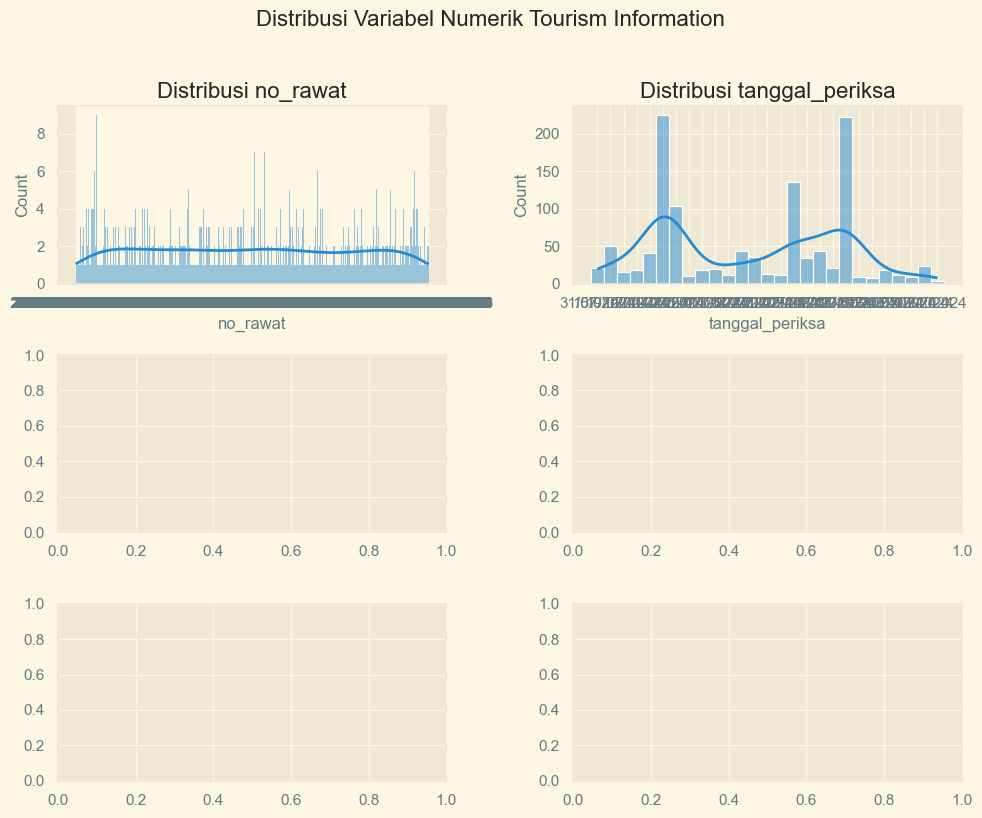

In [23]:
numeric_cols_information = ['no_rawat', 'tanggal_periksa']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
fig.suptitle('Distribusi Variabel Numerik Tourism Information', y=1.02, fontsize=16)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Loop through numeric columns and create histograms
for i, col in enumerate(numeric_cols_information):
    sns.histplot(df_bpjs[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribusi {col}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()